In [1]:
#load MNIST data

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
#glace data
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

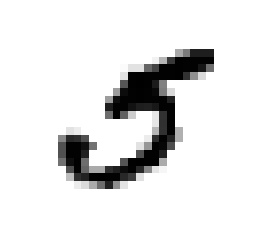

In [4]:
#visu some image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, 
           cmap = matplotlib.cm.binary,
           interpolation = "nearest")
plt.axis("off")
plt.show()

In [6]:
#split train and test sets. keep the order consistant

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]


In [69]:
#train a binay classifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#SGD (Stochastic Gradient Descent classifier is good at hanlding large dataset and online learning)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) #random state can have reproducible results
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])


array([ True], dtype=bool)

In [9]:
#performance measurement -cross valiation(not good for skewed dataset)
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([ 0.96585,  0.95865,  0.96515])

In [15]:
#some funcation as cross_val_score() 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96585
0.95865
0.96515


In [11]:
#performance measurement -confusion matrix

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53801,   778],
       [ 1429,  3992]], dtype=int64)

In [29]:
#precision and recore
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

0.83689727463312369

In [30]:
#precision/recall tradeoff (decision_function)

y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

<function matplotlib.pyplot.show>

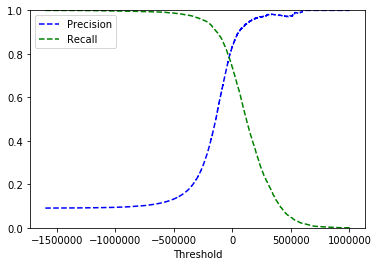

In [33]:
# get right threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

if y_scores.ndim == 2:
    y_scores = y_scores[:,1]

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#plot
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

In [35]:
#suppose 90%precision is needed
y_train_pred_90 = (y_scores > 70000)

precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.60339420771075447

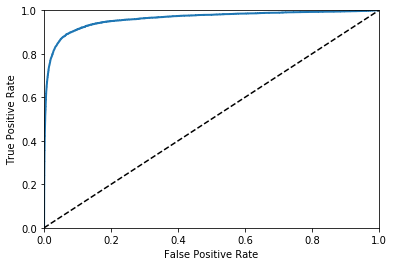

In [40]:
#performance measurement ROC (Receiver Operating Characteristic)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#plot
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96149846292540919

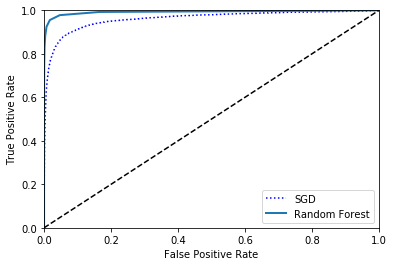

In [44]:
#random frest calssifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr,tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

roc_auc_score(y_train_5, y_scores_forest)

# Multiclass classification

In [48]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 3.])

In [49]:
#sklean train 10 binary classifiers, show their scores.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-117987.21953576, -524035.89192459, -409753.43525049,
         -35351.51255334, -417457.5994907 ,  -75413.71547079,
        -688129.43972841, -300386.21093502, -689307.47809258,
        -620037.50994577]])

In [53]:
#show which class has the max score and which class it belongs
np.argmax(some_digit_scores)
sgd_clf.classes_


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [56]:
#evaluate
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86167766,  0.86774339,  0.8699805 ])

In [57]:
#scale input may improve accurancy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90921816,  0.90874544,  0.91163675])

In [58]:
# error analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5727,    3,   29,   10,   10,   48,   45,   10,   37,    4],
       [   1, 6491,   47,   23,    5,   40,    6,   13,  105,   11],
       [  57,   32, 5355,   85,   80,   29,   92,   48,  165,   15],
       [  48,   44,  141, 5324,    2,  244,   34,   54,  144,   96],
       [  21,   30,   45,    7, 5362,    9,   57,   33,   80,  198],
       [  70,   40,   41,  177,   75, 4615,  108,   30,  174,   91],
       [  33,   26,   45,    1,   37,   93, 5639,    4,   40,    0],
       [  29,   26,   64,   26,   60,   11,    5, 5827,   17,  200],
       [  50,  160,   68,  154,   13,  165,   65,   30, 5006,  140],
       [  45,   34,   26,   80,  164,   41,    2,  239,   72, 5246]], dtype=int64)

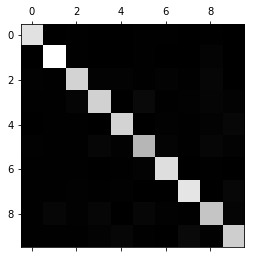

In [59]:
#plot the above array
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

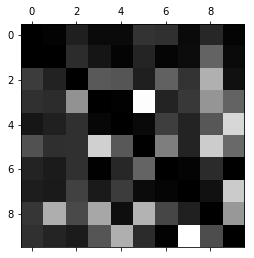

In [62]:
#forcus on errors. columns are predited, the light it is, the more confused with other, the darker, the more confident.
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilable Classification

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)





KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
#performance evaulate
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")
